# Project 02 - Image Processing

## Student Information

- Full name:
- Student ID:
- Class:

## Required Libraries

In [2]:
# IMPORT YOUR LIBS HERE
import matplotlib.pyplot as plt
import PIL
import numpy as np

## Function Definitions

In [3]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image
    '''

    # YOUR CODE HERE
    img = PIL.Image.open(img_path)
    return np.asarray(img)


def show_img(img):
    '''
    Show image

    Parameters
    ----------
    img : <your type>
        Image
    '''

    # YOUR CODE HERE
    plt.imshow(img)
    plt.show()


def save_img(img, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img : <your type>
        Image
    img_path : str
        Path of image
    '''

    # YOUR CODE HERE
    ext = img_path.split('.')[-1].lower()
    if ext in ['png', 'pdf']:
        img.save(img_path, format=ext.upper())
    else:
        print("Unsupported file format. Please use either 'png' or 'pdf'.")


#--------------------------------------------------------------------------------
# YOUR FUNCTIONS HERE

<ins>Note:</ins> For clarity, include docstrings with each function.

## Your tests

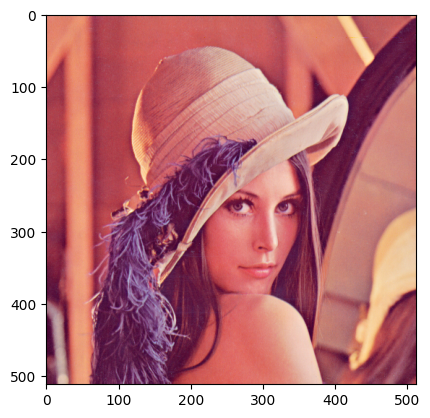

(512, 512, 3)
[  0   0   1 ... 510 511 511]
[  0   0   1 ... 510 511 511]
[[  0]
 [  0]
 [  1]
 ...
 [510]
 [511]
 [511]]


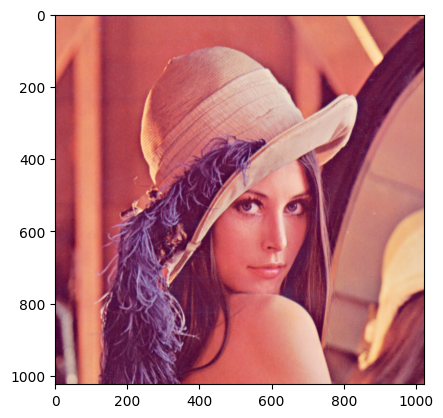

In [20]:
# YOUR CODE HERE
def change_brightness(img, level):
    '''
    Change the brightness of the image

    Parameters
    ----------
    img : np.ndarray
        Image array
    level : int
        Brightness level to be added

    Returns
    -------
    np.ndarray
        Brightness adjusted image
    '''

    # Change to float => avoid overflow
    new_img = img.astype(float) + level

    # Change back to int => normal rbg value
    new_img = np.clip(new_img, 0, 255).astype(int)

    return new_img

def change_contrast(img, level):
    '''
    Change the contrast of the image

    Parameters
    ----------
    img : np.ndarray
        Image array
    level : float
        Contrast adjustment factor.
        Values > 1 increase contrast, values between 0 and 1 decrease contrast.

    Returns
    -------
    np.ndarray
        Contrast adjusted image
    '''

    # Convert image to float to prevent overflow/underflow
    img = img.astype(float)

    # Calculate the mean of the image
    mean = np.mean(img)

    # Apply contrast adjustment
    new_img = mean + level * (img - mean)

    # Clip values to be in the range [0, 255]
    new_img = np.clip(new_img, 0, 255).astype(int)

    return new_img

def flip_image(img, axis):
    '''
    Flip the image along the specified axis

    Parameters
    ----------
    img : np.ndarray
        Image array
    axis : str
        Axis along which to flip the image ('Vertical' or 'Horizontal')

    Returns
    -------
    np.ndarray
        Flipped image
    '''

    if axis == 'Horizontal':
        new_img = img[::-1]
    if axis == 'Vertical':
        new_img = img[:, ::-1]
    return new_img

def green_blue_yellow_scaling_image(img):
    gby_img = 0.2989 * img[:, :, 0] + 0.5870 * img[:, :, 1] + 0.1140 * img[:, :, 2]
    gby_img = gby_img.astype(np.uint8)
    return gby_img

def grayscaling_image(img):
    '''
    Convert an RGB image to grayscale

    Parameters
    ----------
    img : np.ndarray
        RGB image array

    Returns
    -------
    np.ndarray
        Grayscale image
    '''

    # img = img.astype(float)
    # Calculate the gray value
    gray_pixels = np.dot(img[..., 0:3].astype(float), [0.2989, 0.5870, 0.1140])

    # Put the gray value across the rgb
    gray_img = np.stack((gray_pixels, gray_pixels, gray_pixels), axis=-1)

    # Over/Underflow  check
    gray_img = np.clip(gray_img, 0, 255)

    return gray_img.astype(int)

def add_sepia_filter(img):
    '''
    Convert an RGB image to sepia

    Parameters
    ----------
    img : np.ndarray
        RGB image array

    Returns
    -------
    np.ndarray
        Image with sepia filter
    '''

    sepia_filter = np.array([[0.393, 0.769, 0.189],
                            [0.349, 0.686, 0.168],
                            [0.272, 0.534, 0.131]])

    sepia_red_pixels = np.dot(img[..., 0:3], sepia_filter[0])
    sepia_green_pixels = np.dot(img[..., 0:3], sepia_filter[1])
    sepia_blue_pixels = np.dot(img[..., 0:3], sepia_filter[2])

    sepia_img = np.stack((sepia_red_pixels, sepia_green_pixels, sepia_blue_pixels), axis=-1)

    sepia_img = np.clip(sepia_img, 0, 255)

    return sepia_img.astype(int)

def conv2d_fast(img, krn):
    
    is0, is1, ks0, ks1 = *img.shape, *krn.shape
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1
    
    ix0 = np.arange(ks0)[:, None] + np.arange(rs0)[None, :]
    ix1 = np.arange(ks1)[:, None] + np.arange(rs1)[None, :]
    
    res = krn[:, None, :, None] * img[(ix0.ravel()[:, None], ix1.ravel()[None, :])].reshape(ks0, rs0, ks1, rs1)
    res = res.transpose(1, 3, 0, 2).reshape(rs0, rs1, -1).sum(axis = -1)

    return res

def conv2d_faster(img, krn):
    is0, is1 = img.shape
    ks0, ks1 = krn.shape
    
    # Compute the shape of the output
    rs0, rs1 = is0 - ks0 + 1, is1 - ks1 + 1

    # Define the strides for the input image
    strides = img.strides + img.strides
    img_2d = np.lib.stride_tricks.as_strided(img, shape=(rs0, rs1, ks0, ks1), strides=strides)
    
    # Perform the convolution
    result = np.tensordot(img_2d, krn, axes=((2, 3), (0, 1)))
    
    return result

def convolution_v7(img, krn):
    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d_fast(img_r, krn)
    new_img_b = conv2d_fast(img_b, krn)
    new_img_g = conv2d_fast(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    return new_img.astype(int)

def convolution_v8(img, krn):
    img_r = img[:, :, 0]
    img_b = img[:, :, 1]
    img_g = img[:, :, 2]

    new_img_r = conv2d_faster(img_r, krn)
    new_img_b = conv2d_faster(img_b, krn)
    new_img_g = conv2d_faster(img_g, krn)

    new_img = np.stack((new_img_r, new_img_b, new_img_g), axis=-1)

    return new_img.astype(int)

def crop_circle(img):
    h, w = img.shape[0], img.shape[1]
    r = h//2

    center_x, center_y = h//2, w//2

    Y, X = np.ogrid[:h, :w]

    # Contrast the coordinate within the circle(0 and 1)
    mask = (X - center_x)**2 + (Y - center_y)**2 <= r**2

    new_img = img * mask[:, :, np.newaxis]

    return new_img

def crop_center_square(image_array, crop_size):
    '''
    Crop a square from the center of the image.

    Parameters
    ----------
    image_array : np.ndarray
        3D numpy array representing the image (height, width, channels).
    crop_size : int
        The size of the square crop(pixel).

    Returns
    -------
    np.ndarray
        Cropped square image as a 3D numpy array.
    '''
    height, width, channels = image_array.shape
    
    # Ensure the crop size is not larger than the image dimensions
    crop_size = min(crop_size, height, width)
    
    # Calculate the center of the image
    center_y, center_x = height // 2, width // 2
    
    # Calculate the coordinates for cropping
    half_crop = crop_size // 2
    y1 = max(center_y - half_crop, 0)
    y2 = min(center_y + half_crop, height)
    x1 = max(center_x - half_crop, 0)
    x2 = min(center_x + half_crop, width)
    
    # Crop the image
    cropped_image = image_array[y1:y2, x1:x2]
    
    # Handle the case where the cropped area is smaller than the desired crop_size
    if cropped_image.shape[0] < crop_size or cropped_image.shape[1] < crop_size:
        padded_image = np.pad(cropped_image, ((0, crop_size - cropped_image.shape[0]), (0, crop_size - cropped_image.shape[1]), (0, 0)), mode='constant')
        return padded_image
    
    return cropped_image

# https://www.youtube.com/watch?v=v9CFu4r6tPY
def zoom_img(img, scale):
    new_rows = int(scale*img.shape[0])
    new_cols = int(scale*img.shape[1])

    zoomed_img = np.zeros((new_rows, new_cols, img.shape[2]), dtype=int)

    # for i in range(new_rows):
    #     for j in range(new_cols):
    #         zoomed_img[i, j, :] = img[int(i/scale), int(j/scale), :]

    row_indices = np.clip((np.arange(new_rows) / scale).astype(int), 0, img.shape[0] - 1)
    col_indices = np.clip((np.arange(new_cols) / scale).astype(int), 0, img.shape[1] - 1)

    print(row_indices)
    print(col_indices)

    row_indices = row_indices[:, np.newaxis]
    print(row_indices)

    # Use advanced indexing to construct the zoomed image
    zoomed_img = img[row_indices, col_indices, :]
    zoomed_img = np.clip(zoomed_img, 0 , 255)

    return zoomed_img

#   https://techmaster.vn/posts/35474/convolution-tich-chap-giai-thich-bang-code-thuc-te
# https://www.youtube.com/watch?v=8rrHTtUzyZA
test_img_path = "Picture/Test/test10.png"

img = read_img(test_img_path)
show_img(img)
print(img.shape)

zoomed_img = zoom_img(img, 2)
show_img(zoomed_img)

# crop_img = crop_center_square(img, 250)
# show_img(crop_img)

# gray_scaled_img = grayscaling_image(img)
# show_img(gray_scaled_img[:, :, :])

# print(img)
# print(red_img.shape)

# brightness_img = change_brightness(img, -100)
# show_img(brightness_img)

# contrast_img = change_contrast(img, 0.5)
# show_img(contrast_img)

# vertical_img = flip_image(img, 'Vertical')
# show_img(vertical_img)

# horizontal_img = flip_image(img, 'Horizontal')
# show_img(horizontal_img)

# gray_scaled_img = grayscaling_image(img)
# show_img(gray_scaled_img)

# sepia_img = add_sepia_filter(img)
# show_img(sepia_img)

# circle_img = crop_circle(img)
# show_img(circle_img)

# blur_kernel = np.ones((3,3))/9
# sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
# sharpen_img = convolution_v7(img, blur_kernel)
# show_img(sharpen_img)

# blur_kernel = np.ones((3,3), dtype=float)*1/9
# print(blur_kernel)
# print(*img.shape)
# blur_img = conv2d_slow(img, blur_kernel)
# show_img(blur_img)

## Main FUNCTION

In [ ]:
# YOUR CODE HERE

In [ ]:
# Call main function